In [2]:
import base64
import json
import pickle
from pathlib import Path
from typing import Any, Iterator

import matplotlib.pyplot as plt
import networkx as nx
import tree_sitter
import uuid6
from function_pipes import pipe
from requests import get
from tree_sitter_languages import get_parser
from uuid6 import uuid7

from mt.definitions import REPO_DIR
from mt.helper import api_get, flatten

from py2cfg import CFGBuilder, CFG
import regex as re
from collections import defaultdict
from matplotlib.lines import Line2D
import random
from mt.featurize_repo import decode_file_contents

In [7]:
parser = get_parser("python")
tree = parser.parse(b"from x.y.z import g\nimport a\nfrom x import z\nimport a.b.c\nimport a, b, c")
root = tree.root_node

In [244]:
type(root)

tree_sitter.Node

In [189]:
for node in root.children:
    if node.type == "import_statement":
        print([n.text for n in node.children_by_field_name("name")])
    elif node.type == "import_from_statement":
        print([n.text for n in node.children_by_field_name("module_name")])

[b'x.y.z']
[b'a']
[b'x']
[b'a.b.c']
[b'a', b'b', b'c']


# Old processing (less descriptive edges)

In [180]:
root.sexp()

'(module (import_from_statement module_name: (dotted_name (identifier) (identifier) (identifier)) name: (dotted_name (identifier))) (import_statement name: (dotted_name (identifier))) (import_from_statement module_name: (dotted_name (identifier)) name: (dotted_name (identifier))) (import_statement name: (dotted_name (identifier) (identifier) (identifier))))'

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-128k-instruct", trust_remote_code=True)

def get_embeddings(texts):
    encoded_input = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input, output_hidden_states=True)
    # Use the mean of the output token embeddings as the feature vector
    print(dir(outputs))
    embeddings = outputs.hidden_states[-1].mean(dim=1)[0]
    return embeddings

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
get_embeddings(str(root.text))

['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'logits', 'loss', 'move_to_end', 'past_key_values', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']


tensor([-0.7601, -0.1187,  0.4789,  ..., -0.1598, -0.3885,  0.0113])

In [176]:
# Filtering for anon nodes is necessary to avoid a lot of noise and non important features??
def tree_to_graph(root: tree_sitter.Node, with_anon: bool = False) -> nx.DiGraph:
    G = nx.DiGraph()
    todo = [root]
    while todo:
        node = todo.pop()
        if with_anon or node.is_named:
            G.add_node(node.id, type=node.type)
        for child in node.children:
            if with_anon or child.is_named:
                G.add_edge(node.id, child.id)
            todo.append(child)
    return G

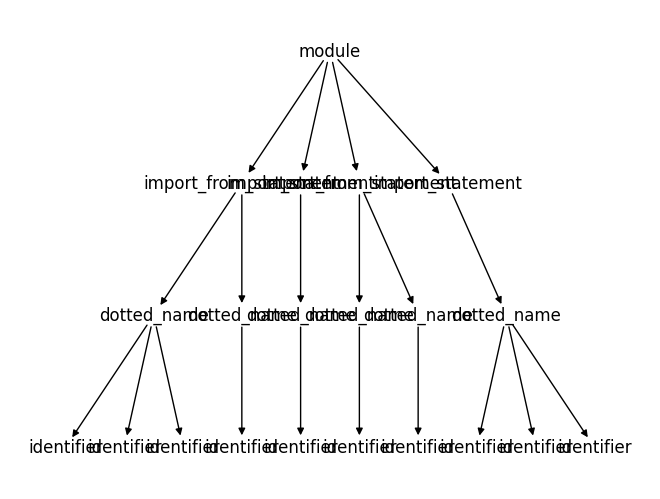

In [177]:
T = tree_to_graph(root)
labels = nx.get_node_attributes(T, "type")
pos = nx.nx_agraph.graphviz_layout(T, prog="dot")
nx.draw(T, pos, labels=labels, node_color="none")

In [10]:
def save_graph_to_pickle(graph: nx.Graph, path: Path):
    with open(path, "wb") as f:
        pickle.dump(graph, f)

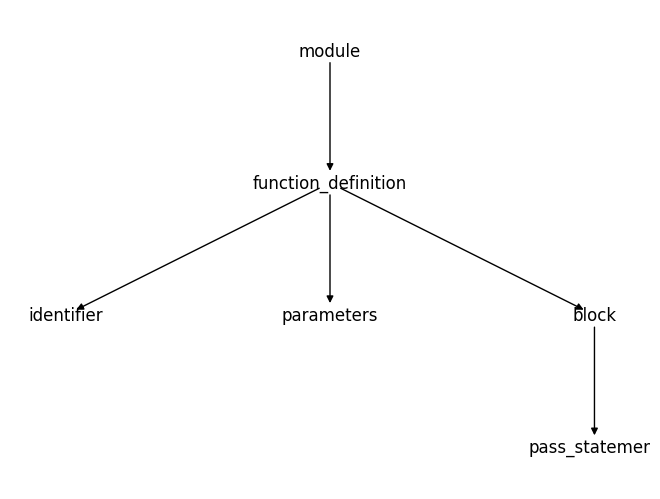

In [9]:
with open("test_tree.pickle", "wb") as f:
    pickle.dump(T, f)

with open("test_tree.pickle", "rb") as f:
    T = pickle.load(f)

nx.draw(T, pos, labels=labels, node_color="none")

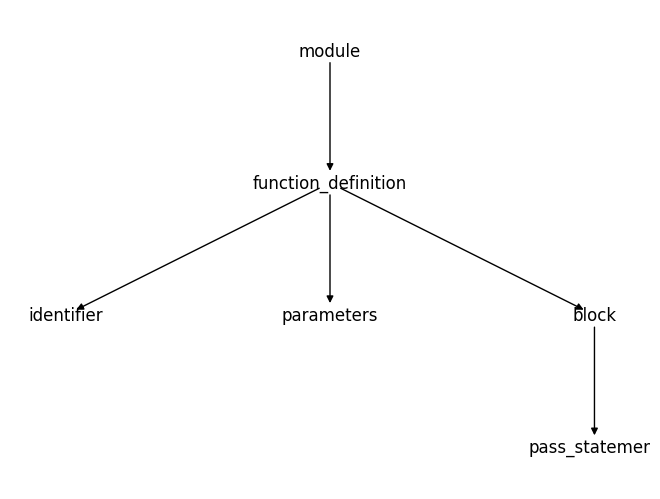

In [13]:
with open("test_tree.json", "w") as f:
    json.dump(nx.node_link_data(T), f)

with open("test_tree.json", "r") as f:
    T = nx.node_link_graph(json.load(f))

nx.draw(T, pos, labels=labels, node_color="none")

In [11]:
parser = get_parser("python")

def read_bytes(path: Path) -> bytes:
    with open(path, "rb") as f:
        return f.read()

def get_tree_from_code(code: bytes) -> nx.DiGraph:
    return pipe(code, parser.parse, lambda tree: tree.root_node, tree_to_graph)

In [1]:
# featurization from blob
blob_link = "https://api.github.com/repos/3b1b/manim/git/blobs/127e438d07fe8c53357fd84368652c81124fc06b"
response = get(blob_link)
response

<Response [200]>

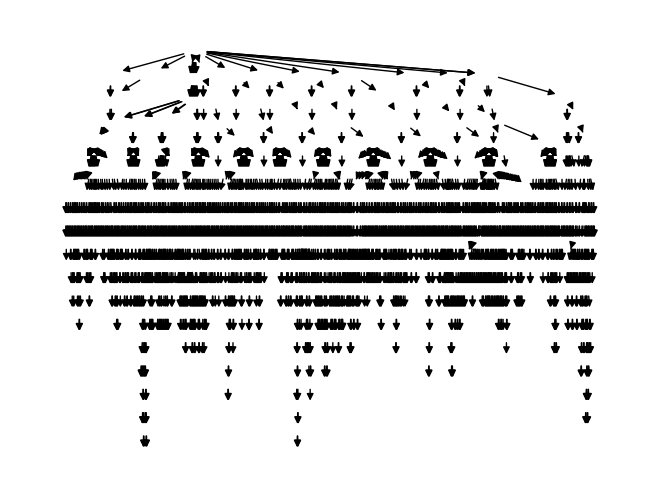

In [10]:
j = response.json()
code = base64.b64decode(j["content"])
tree = get_tree_from_code(code)
labels = nx.get_node_attributes(tree, "type")
pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
nx.draw(tree, pos, node_color="none")

In [11]:
with open("one_blob.pickle", "wb") as f:
    pickle.dump(tree, f)

In [1]:
# commit featurization pipeline
specific_repo = REPO_DIR / "3b1b/manim"
with open (specific_repo / "repo.json") as f:
    repo_json = json.load(open(specific_repo / "repo.json"))
commits = list(api_get(repo_json['commits_url'].format(**{"/sha": "?per_page=100"})))
with open(specific_repo / "commits.json", "w") as f:
    json.dump(commits, f, indent=4)

In [2]:
all_commits = flatten([response['items'] for response in commits])
# all_commits[0]

In [5]:
commits_dir = specific_repo / "commits"
commits_dir.mkdir(exist_ok=True)


In [3]:
all_commits[0]

{'sha': 'd8428585f84681055fed8aa3fabfb6ae95e4a0ff',
 'node_id': 'C_kwDOAfLOx9oAKGQ4NDI4NTg1Zjg0NjgxMDU1ZmVkOGFhM2ZhYmZiNmFlOTVlNGEwZmY',
 'commit': {'author': {'name': 'Grant Sanderson',
   'email': 'grant@3blue1brown.com',
   'date': '2023-02-15T17:40:43Z'},
  'committer': {'name': 'GitHub',
   'email': 'noreply@github.com',
   'date': '2023-02-15T17:40:43Z'},
  'message': 'Merge pull request #1994 from 3b1b/video-work\n\nSeveral bug fixes',
  'tree': {'sha': 'a2c7aee2d7acc255d5ff9f6e5f3be47fb0677221',
   'url': 'https://api.github.com/repos/3b1b/manim/git/trees/a2c7aee2d7acc255d5ff9f6e5f3be47fb0677221'},
  'url': 'https://api.github.com/repos/3b1b/manim/git/commits/d8428585f84681055fed8aa3fabfb6ae95e4a0ff',
  'comment_count': 0,
  'verification': {'verified': True,
   'reason': 'valid',
   'signature': '-----BEGIN PGP SIGNATURE-----\n\nwsBcBAABCAAQBQJj7RkbCRBK7hj4Ov3rIwAAoTwIAEb8eyfVUCpjtEr9kV0PWxZs\nDsEtHcp+gzXvpnmzUKUBx8GoOISNLyUSPlYXC2RSlVy9AV0TXDUWbIDBByI7o6/H\nnQfFTxe4BygGNI3HIE

In [12]:
def handle_git_tree(
    git_tree: dict[str, str], path: str = ""
) -> Iterator[tuple[dict[str, Any], str]]:
    for item in git_tree["tree"]:
        if item["type"] == "tree":
            tree = next(api_get(item["url"]))
            yield from handle_git_tree(tree, path + item["path"] + "/")
        if item["type"] == "blob":
            blob = next(api_get(item["url"]))
            yield blob, path + item["path"]


def handle_commit(commit: dict[str, Any], save_files: bool = False) -> None:
    sha = commit["sha"]
    commit_dir = commits_dir / sha
    commit_dir.mkdir(exist_ok=True)
    with open(commit_dir / "commit.json", "w") as f:
        json.dump(commit, f, indent=4)
    git_tree = commit["commit"]["tree"]["url"]
    tree = next(api_get(git_tree))
    with open(commit_dir / "tree.json", "w") as f:
        json.dump(tree, f, indent=4)
    file_dir = commit_dir / "files"
    file_dir.mkdir(exist_ok=True)
    featurized_dir = commit_dir / "featurized"
    featurized_dir.mkdir(exist_ok=True)
    for item, path in handle_git_tree(tree):
        if save_files:
            item_path = file_dir / (path + ".json")
            item_path.parent.mkdir(exist_ok=True, parents=True)
            with open(item_path, "w") as f:
                json.dump(item, f, indent=4)
        if path.endswith(".py"):
            uuid = uuid7().hex
            code = base64.b64decode(item["content"])
            tree = get_tree_from_code(code)
            tree_path = featurized_dir / (uuid + ".pickle")
            with open(tree_path, "wb") as f:
                pickle.dump(tree, f)
            with open(featurized_dir / (uuid + ".json"), "w") as f:
                json.dump({"path": path, "file_size": item["size"]}, f, indent=4)


handle_commit(all_commits[0])

{'path': 'manimlib/utils/sounds.py', 'file_size': 328}


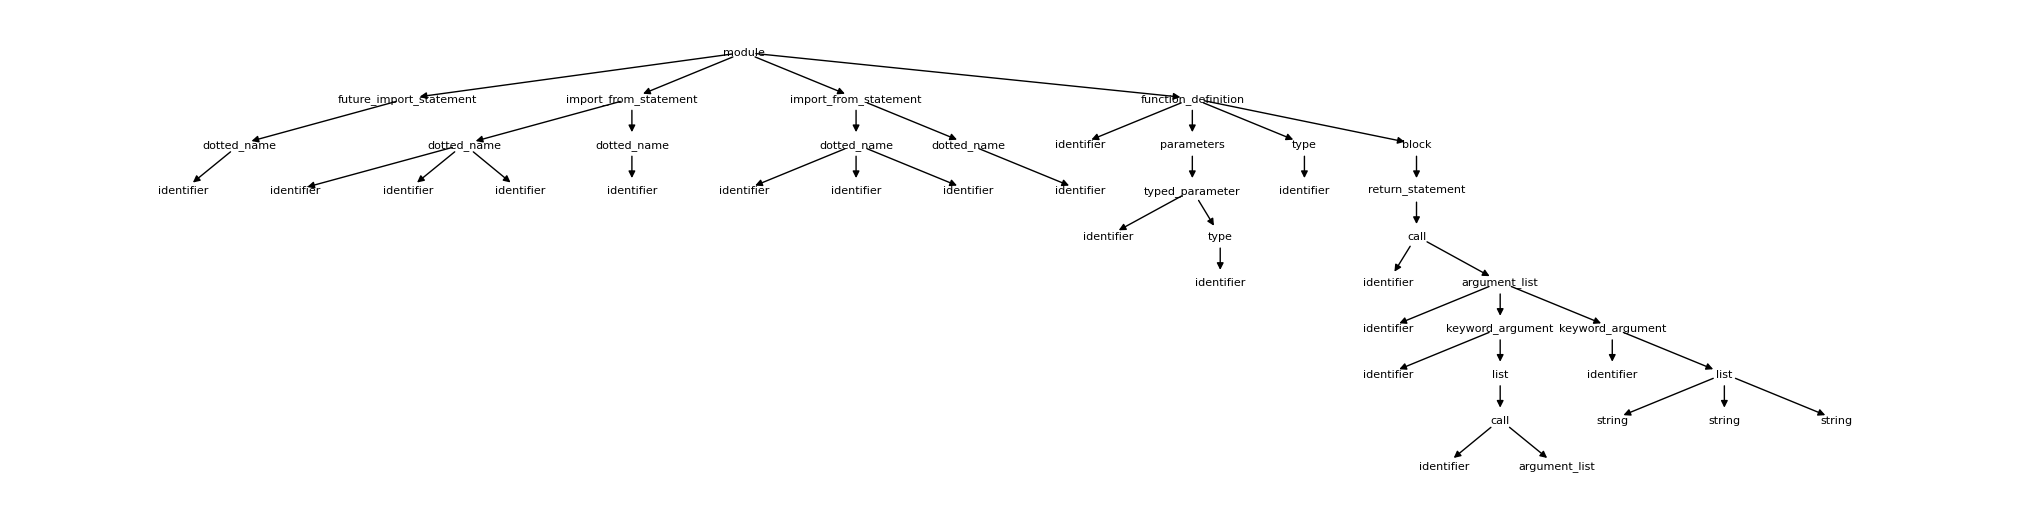

In [9]:
def read_json(path: Path) -> dict:
    with open(path, "r") as f:
        return json.load(f)


def read_pickle(path: Path) -> Any:
    with open(path, "rb") as f:
        return pickle.load(f)


featurized_dir = Path(
    "/home/fox/Projects/learning-portfolio/university/masters/masters-thesis/data/repos/3b1b/manim/commits/d8428585f84681055fed8aa3fabfb6ae95e4a0ff/featurized"
)
items = [
    {"metadata": read_json(item), "tree": read_pickle(item.with_suffix(".pickle"))}
    for item in featurized_dir.iterdir()
    if item.suffix == ".json"
]

items.sort(key = lambda item: item["metadata"]["file_size"])
index = 10
print(items[index]["metadata"])
labels = nx.get_node_attributes(items[index]['tree'], "type")
pos = nx.nx_agraph.graphviz_layout(items[index]['tree'], prog="dot")
fig = plt.figure(1, figsize=(20, 5))
nx.draw(items[index]['tree'], pos, node_color="none", labels=labels, font_size=8)

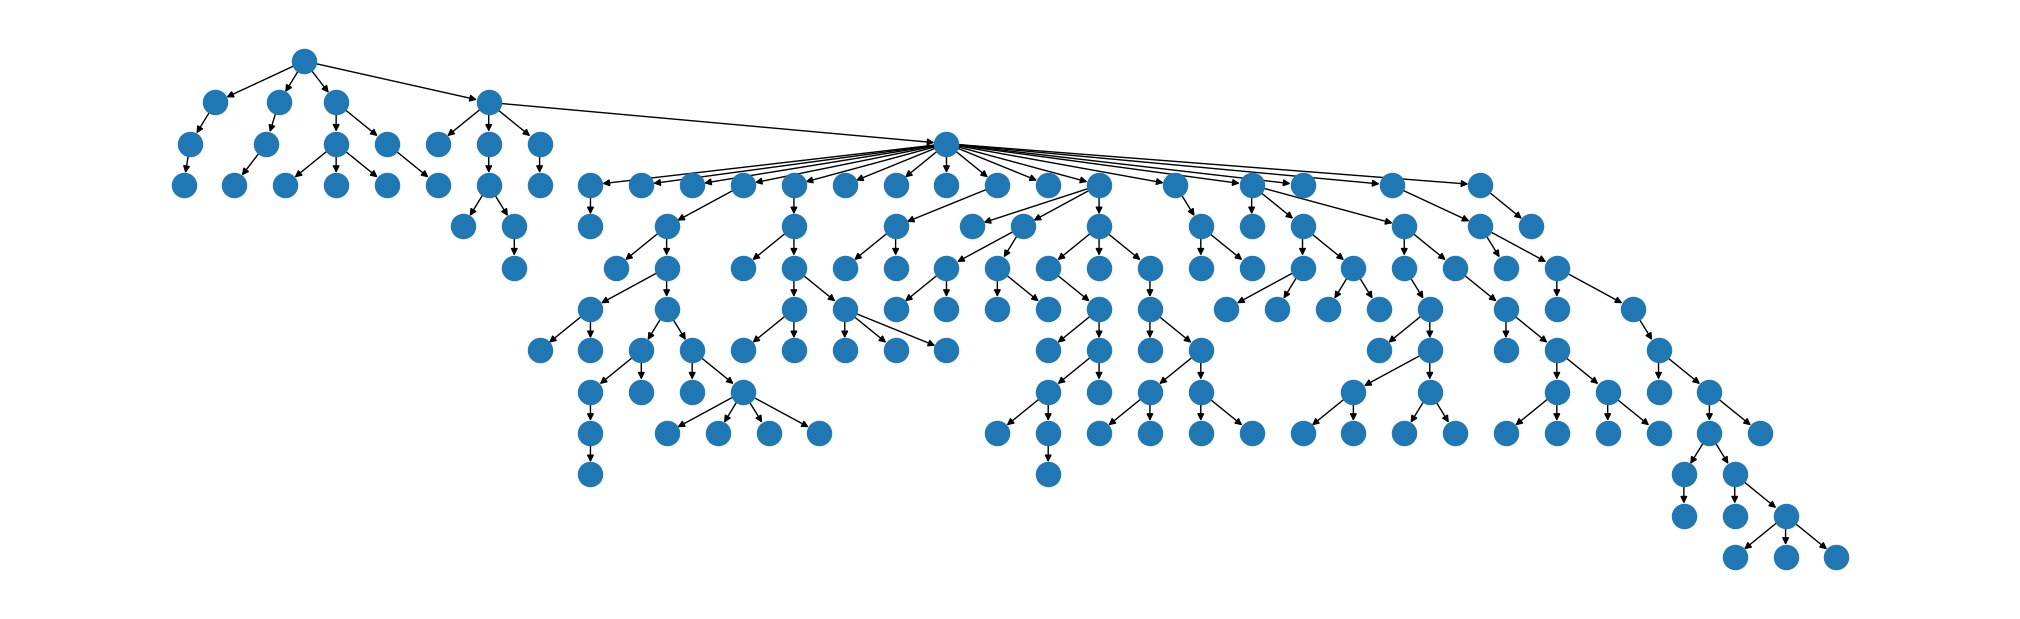

In [93]:
fig = plt.figure(1, figsize=(20, 6))
nx.draw(items[index]['tree'], pos)

In [88]:
with open("/home/fox/Projects/learning-portfolio/university/masters/masters-thesis/data/repos/3b1b/manim/commits/d8428585f84681055fed8aa3fabfb6ae95e4a0ff/files/manimlib/utils/sounds.py.json", "r") as f:
    item = json.load(f)

code = base64.b64decode(item["content"])
code
with open("example_code.py", "wb") as f:
    f.write(code)

# New processing (more descriptive edges)

In [5]:
file_path = Path("~/something/something/manim/manim/repo/some/folder/structure/file.py").expanduser()

def tree_to_graph(root: tree_sitter.Node, with_anon: bool = True) -> nx.DiGraph:
    G = nx.DiGraph()
    todo = [(root, uuid6.uuid7().hex)]
    occurances =  {}

    while todo:
        node, new_id = todo.pop()

        if with_anon or node.is_named:
            start_line, start_col = node.start_point
            end_line, end_col = node.end_point

            G.add_node(
                new_id,
                type=node.type,
                start_line=start_line + 1,
                end_line=end_line + 1,
                start_col=start_col,
                end_col=end_col,
            )
        for child in node.children:
            if with_anon or child.is_named:
                child_id = uuid6.uuid7().hex
                G.add_edge(new_id, child_id, type="child")
            todo.append((child, child_id))
    return G


def get_tree_from_code(code: bytes, file_path: Path) -> nx.DiGraph:
    ast = pipe(code, parser.parse, lambda tree: tree.root_node)
    return tree_to_graph(ast, file_path)


def save_graph_to_pickle(graph: nx.Graph, path: Path):
    with open(path, "wb") as f:
        pickle.dump(graph, f)


# TODO: https://chat.openai.com/c/f858a84a-0811-4187-b0c5-97765b2eab11
# AST trees
def bytes_to_ast(file_content: bytes) -> dict:
    "Reads the file content and returns the AST as a json nx graph."
    # TODO: if not efficient enough, transform to .pkl files
    return pipe(file_content, get_tree_from_code, nx.node_link_data)

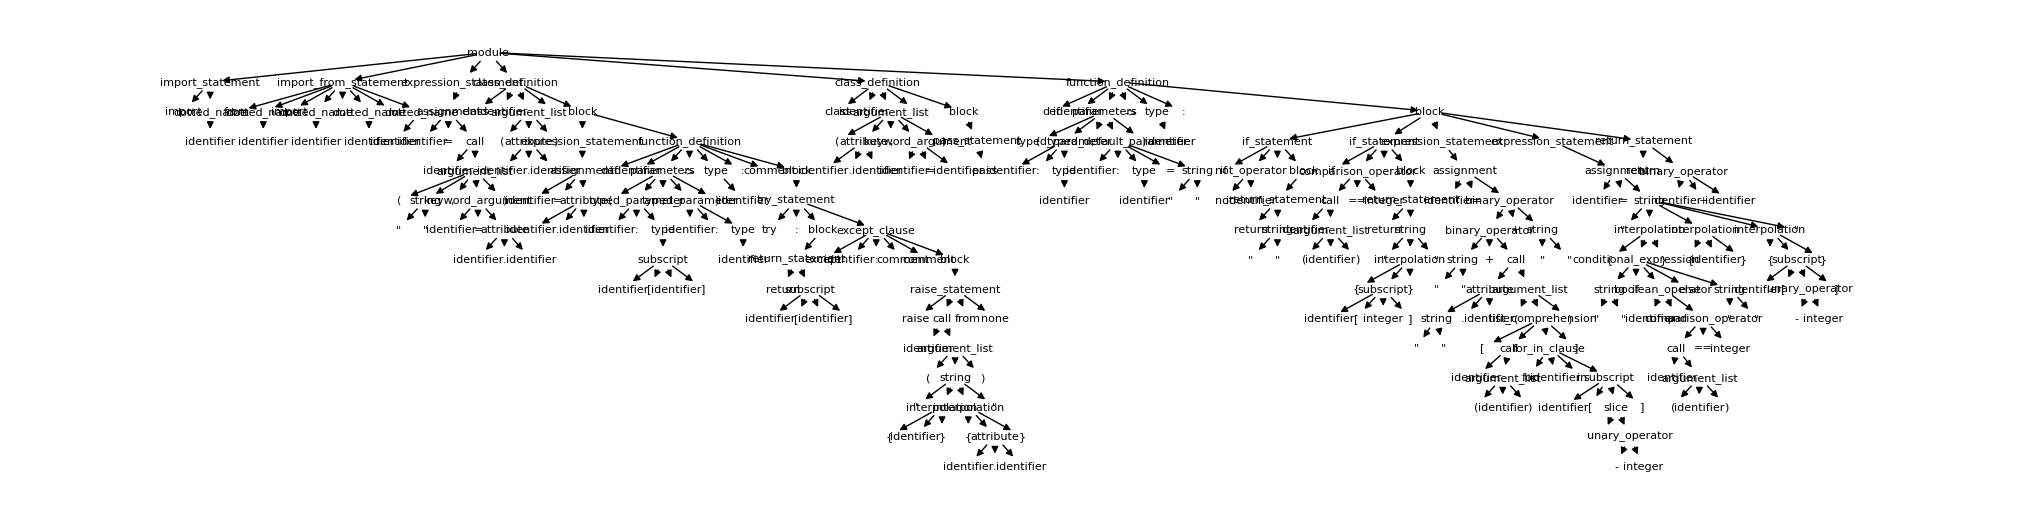

In [8]:
code = b"""
import enum
from typing import Sequence, Type, TypeVar

T = TypeVar("T", bound=enum.Enum)


class StrEnumMeta(enum.EnumMeta):
    auto = enum.auto

    def from_str(self: Type[T], member: str) -> T:  # type: ignore[misc]
        try:
            return self[member]
        except KeyError:
            # TODO: use `add_suggestion` from torchvision.prototype.utils._internal to improve the error message as
            #  soon as it is migrated.
            raise ValueError(f"Unknown value '{member}' for {self.__name__}.") from None


class StrEnum(enum.Enum, metaclass=StrEnumMeta):
    pass


def sequence_to_str(seq: Sequence, separate_last: str = "") -> str:
    if not seq:
        return ""
    if len(seq) == 1:
        return f"'{seq[0]}'"

    head = "'" + "', '".join([str(item) for item in seq[:-1]]) + "'"
    tail = f"{'' if separate_last and len(seq) == 2 else ','} {separate_last}'{seq[-1]}'"

    return head + tail
"""




tree = get_tree_from_code(code, file_path)
# labels = nx.get_node_attributes(tree, "type")
# pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
# nx.draw(tree, pos, labels=labels)

labels = nx.get_node_attributes(tree, "type")
pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
fig = plt.figure(1, figsize=(20, 5))
nx.draw(tree, pos, node_color="none", labels=labels, font_size=8)

In [321]:
cfg = CFGBuilder().build_from_src("", code.decode())
cfg

In [322]:
cfg.build_visual("py2cfg.png", "png")

'py2cfg.png.png'

Gtk-Message: 04:45:25.815: Failed to load module "colorreload-gtk-module"
[296427:296427:0520/044525.826021:ERROR:policy_logger.cc(157)] :components/enterprise/browser/controller/chrome_browser_cloud_management_controller.cc(161) Cloud management controller initialization aborted as CBCM is not enabled. Please use the `--enable-chrome-browser-cloud-management` command line flag to enable it if you are not using the official Google Chrome build.
[296427:296529:0520/044525.894174:ERROR:object_proxy.cc(576)] Failed to call method: org.freedesktop.DBus.Properties.Get: object_path= /org/freedesktop/UPower: org.freedesktop.DBus.Error.ServiceUnknown: The name org.freedesktop.UPower was not provided by any .service files
[296427:296529:0520/044525.894414:ERROR:object_proxy.cc(576)] Failed to call method: org.freedesktop.UPower.GetDisplayDevice: object_path= /org/freedesktop/UPower: org.freedesktop.DBus.Error.ServiceUnknown: The name org.freedesktop.UPower was not provided by any .service files

In [10]:
def coords_to_segment(code: str, start_line: int, end_line: int, start_col: int, end_col: int) -> str:
    """
    Print the specific segment from the code using the start and end lines and columns.
    
    Args:
        code (str): The source code as a string.
        start_line (int): The start line number (1-based index).
        end_line (int): The end line number (1-based index).
        start_col (int): The start column number (0-based index).
        end_col (int): The end column number (0-based index).
    """
    lines = code.splitlines()

    # Validate line numbers
    if not (1 <= start_line <= len(lines) and 1 <= end_line <= len(lines)):
        print("Start or end line number is out of range.")
        return

    # Extract the relevant lines
    if start_line == end_line:
        # Single line segment
        segment = lines[start_line - 1][start_col:end_col]
    else:
        # Multi-line segment
        segment_lines = []
        segment_lines.append(lines[start_line - 1][start_col:])  # First line segment
        for line in range(start_line, end_line - 1):
            segment_lines.append(lines[line])
        segment_lines.append(lines[end_line - 1][:end_col])  # Last line segment
        segment = '\n'.join(segment_lines)
    
    return segment


def camel_to_snake(name: str) -> str:
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()

def class_to_type(class_str: str) -> str:
    return re.search(r"ast\.(\w+)", class_str).group(1)

In [330]:
# Node:
# id: uuid7 hex
# type: the type of the underlying representation
# start_line, end_line, start_col, end_col: position
# node_type: the type of node

def cfg_to_nx(cfg: CFG) -> nx.DiGraph:
    cfg_graph = nx.DiGraph()
    block_to_id = defaultdict(uuid6.uuid7)
    f_bloc_to_id = defaultdict(uuid6.uuid7)

    for block in cfg:
        block_id = block_to_id[block.id].hex
        cfg_graph.add_node(
            block_id,
            type=camel_to_snake(class_to_type(str(block.type()))),
            start_line=block.statements[0].lineno if block.statements else -1,
            end_line=block.statements[-1].end_lineno if block.statements else -1,
            start_col=block.statements[0].col_offset if block.statements else -1,
            end_col=block.statements[-1].end_col_offset if block.statements else -1,
            node_type="cfg_block",
        )

        for statement in block.statements:
            statement_id = uuid6.uuid7().hex
            cfg_graph.add_node(
                statement_id,
                type=camel_to_snake(class_to_type(str(type(statement)))),
                start_line=statement.lineno,
                end_line=statement.end_lineno,
                start_col=statement.col_offset,
                end_col=statement.end_col_offset,
                node_type="cfg_statement",
            )

            cfg_graph.add_edge(block_id, statement_id, type="contains", edge_type="cfg")

        for exit in block.exits:
            if exit.exitcase:
                exitcase_id = uuid6.uuid7().hex
                cfg_graph.add_node(
                    exitcase_id,
                    type=camel_to_snake(class_to_type(str(type(exit.exitcase)))),
                    start_line=getattr(exit.exitcase, "lineno", -1),
                    end_line=getattr(exit.exitcase, "end_lineno", -1),
                    start_col=getattr(exit.exitcase, "col_offset", -1),
                    end_col=getattr(exit.exitcase, "end_col_offset", -1),
                    node_type="cfg_exitcase",
                )
                cfg_graph.add_edge(
                    block_to_id[exit.source.id].hex,
                    exitcase_id,
                    type="exit",
                    edge_type="cfg",
                )
                cfg_graph.add_edge(
                    exitcase_id,
                    block_to_id[exit.target.id].hex,
                    type="exit",
                    edge_type="cfg",
                )
            else:
                cfg_graph.add_edge(
                    block_to_id[exit.source.id].hex,
                    block_to_id[exit.target.id].hex,
                    type="exit",
                    edge_type="cfg",
                )

        for f_block in block.func_blocks:
            f_block_id = f_bloc_to_id[f_block.id].hex
            cfg_graph.add_node(
                f_block_id,
                type=camel_to_snake(class_to_type(str(f_block.type()))),
                start_line=f_block.statements[0].lineno if f_block.statements else -1,
                end_line=f_block.statements[-1].end_lineno if f_block.statements else -1,
                start_col=f_block.statements[0].col_offset if f_block.statements else -1,
                end_col=f_block.statements[-1].end_col_offset if f_block.statements else -1,
                node_type="cfg_f_block",
            )
            cfg_graph.add_edge(block_id, f_block_id, type="call", edge_type="cfg")
            for statement in f_block.statements:
                statement_id = uuid6.uuid7().hex
                cfg_graph.add_node(
                    statement_id,
                    type=camel_to_snake(class_to_type(str(type(statement)))),
                    start_line=statement.lineno,
                    end_line=statement.end_lineno,
                    start_col=statement.col_offset,
                    end_col=statement.end_col_offset,
                    node_type="cfg_statement",
                )

                cfg_graph.add_edge(f_block_id, statement_id, type="contains", edge_type="cfg")

    return cfg_graph

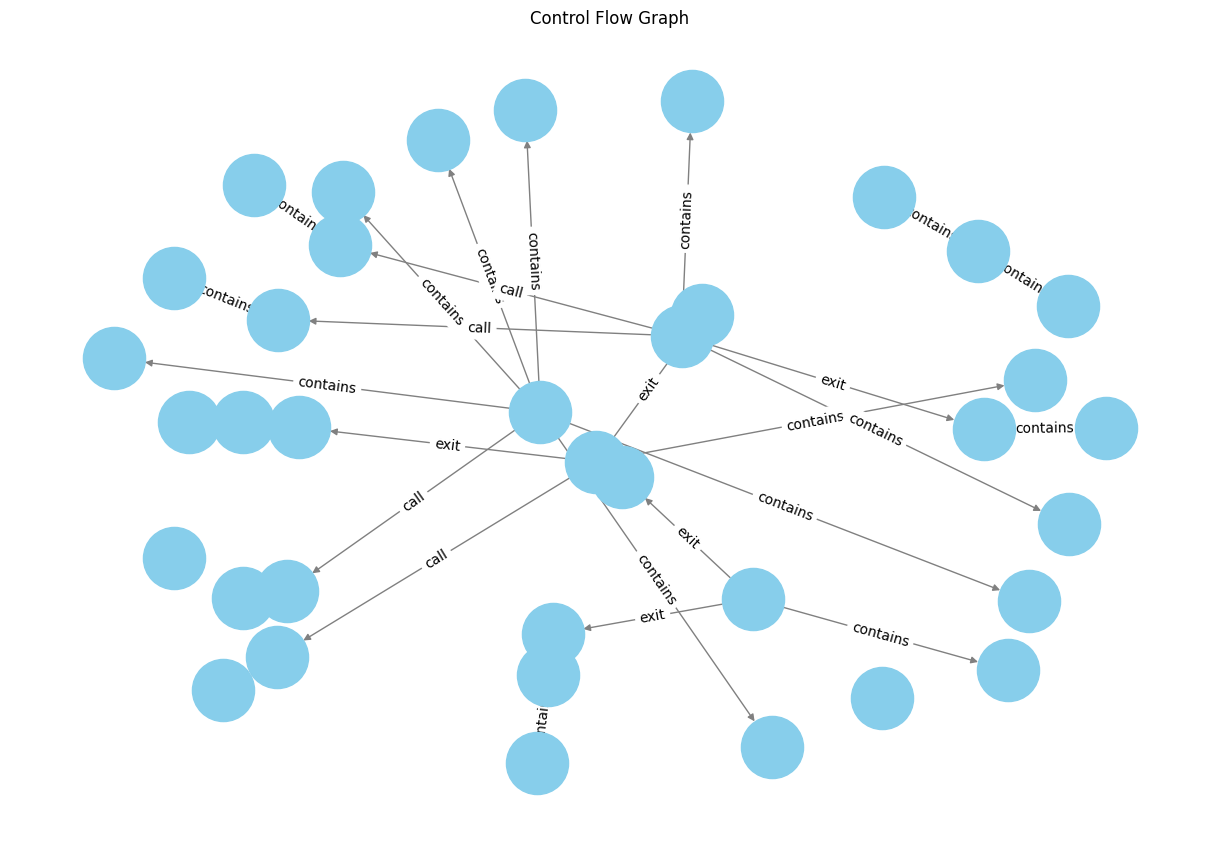

In [331]:
cfg_graph = cfg_to_nx(cfg)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(cfg_graph)  # You can use other layouts like nx.circular_layout or nx.kamada_kawai_layout
nx.draw(cfg_graph, pos, with_labels=False, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_edge_labels(cfg_graph, pos, edge_labels={(u, v): d['type'] for u, v, d in cfg_graph.edges(data=True)})
plt.title("Control Flow Graph")
plt.show()

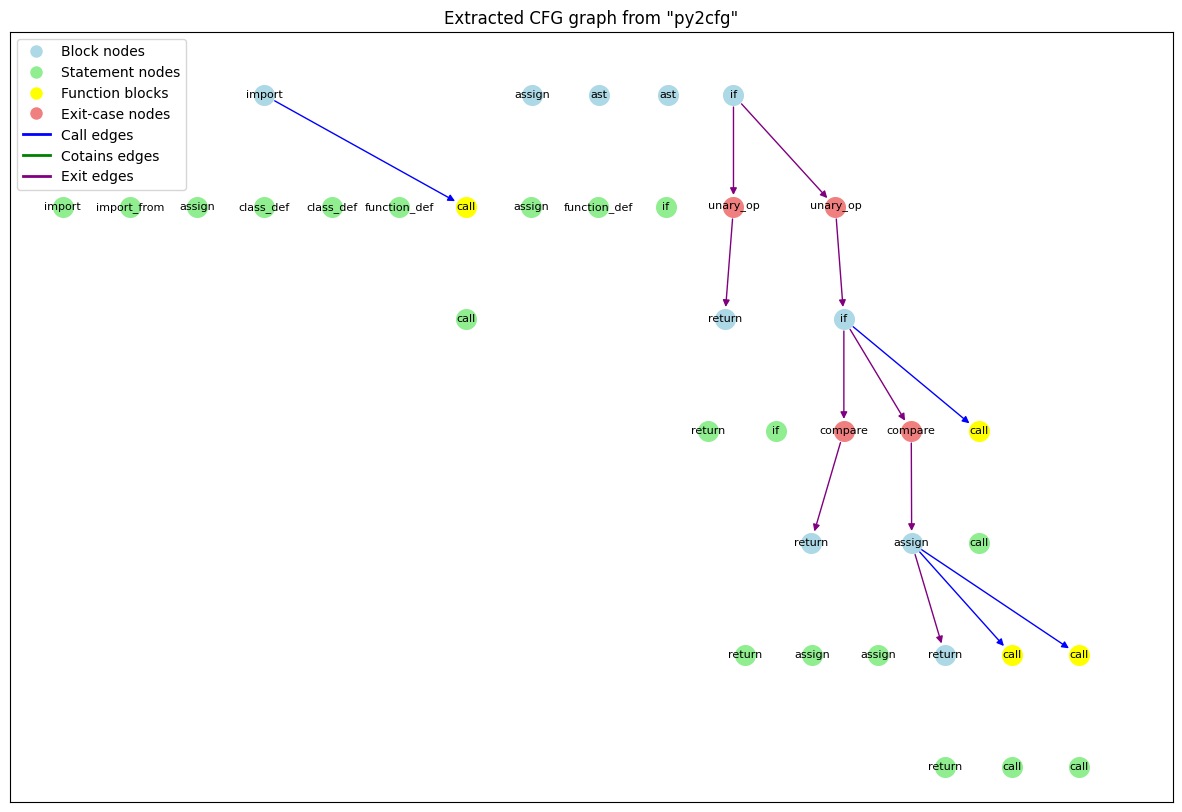

In [344]:
def visualize_graph(graph):
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog="dot")

    cfg_block = [n for n, d in graph.nodes(data=True) if 'cfg_block' == d['node_type']]
    cfg_statement = [n for n, d in graph.nodes(data=True) if 'cfg_statement' == d['node_type']]
    cfg_f_block = [n for n, d in graph.nodes(data=True) if 'cfg_f_block' == d['node_type']]
    cfg_exitcase = [n for n, d in graph.nodes(data=True) if 'cfg_exitcase' == d['node_type']]

    
    # ast_nodes = [n for n, d in graph.nodes(data=True) if 'ast' in d['node_type']]
    # symbol_nodes = [n for n, d in graph.nodes(data=True) if 'ch22' in d['node_type']]
    # dg_nodes = [n for n, d in graph.nodes(data=True) if 'dg' in d['node_type']]

    plt.figure(figsize=(15, 10))

    # Draw nodes with different colors
    nx.draw_networkx_nodes(graph, pos, nodelist=cfg_block, node_color='lightblue', node_size=200, label='Block nodes')
    nx.draw_networkx_nodes(graph, pos, nodelist=cfg_statement, node_color='lightgreen', node_size=200, label='Statement nodes')
    nx.draw_networkx_nodes(graph, pos, nodelist=cfg_f_block, node_color='yellow', node_size=200, label='Function blocks')
    nx.draw_networkx_nodes(graph, pos, nodelist=cfg_exitcase, node_color='lightcoral', node_size=200, label='Exit-case nodes')

    # Explicitly define edge styles
    edge_styles = {
        'call': ('blue', 'solid'),
        'cotains': ('green', 'solid'),
        'exit': ('purple', 'solid'),
        # 'import': ('red', 'solid'),
        # 'last_read': ('orange', 'solid'),
        # 'last_write': ('gray', 'solid'),
        # 'matches': ('brown', 'dotted'),
        # 'may_next_use': ('pink', 'dashed'),
        # 'next_syntax': ('black', 'dotted'),
        # 'occurrence_of': ('cyan', 'dashed'),
        # 'syntax': ('magenta', 'solid')
    }

    # Draw edges with different styles
    for edge_type, (color, style) in edge_styles.items():
        edges = [(u, v) for u, v, d in graph.edges(data=True) if d['type'] == edge_type]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=color, style=style, label=f'{edge_type} edges')

    # Draw labels
    labels = {n: d['type'] for n, d in graph.nodes(data=True)}
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)

    # Custom legend for nodes
    node_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Block nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Statement nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Function blocks'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, label='Exit-case nodes'),
    ]

    # Custom legend for edges
    edge_legend = [
        Line2D([0], [0], color=color, lw=2, linestyle=style, label=f'{edge_type.capitalize()} edges')
        for edge_type, (color, style) in edge_styles.items()
    ]

    # Combine legends
    plt.legend(handles=node_legend + edge_legend, loc='upper left')
    plt.title('Extracted CFG graph from "py2cfg"')
    plt.show()

visualize_graph(cfg_graph)

In [333]:
set(nx.get_edge_attributes(cfg_graph, 'type').values())

{'call', 'contains', 'exit'}

In [304]:
def resolve_local_import(import_path: str, file_path: Path) -> str:
    parts = file_path.parts
    rest = import_path
    while rest.startswith("."):
        parts = parts[:-1]
        _, rest = rest.split(".", maxsplit=1)
    while parts[0] != "repo" or not parts:
        parts = parts[1:]
    return ".".join(parts) + f".{rest}"

def tree_to_graph(root: tree_sitter.Node, file_path: Path, with_anon: bool = True, with_extra: bool = True) -> nx.DiGraph:
    G = nx.DiGraph()
    todo = [(root, None)]  # Start with the root node and no parent
    symbol_nodes = {}  # Store symbol node IDs by identifier content
    last_usage = {}  # Track last usage of each identifier for MayNextUse edges

    while todo:
        node, parent_id = todo.pop()
        node_id = uuid6.uuid7().hex  # Unique ID for each node

        if with_anon or node.is_named:
            start_line, start_col = node.start_point
            end_line, end_col = node.end_point

            # Add node to graph
            G.add_node(
                node_id,
                type=node.type,
                start_line=start_line + 1,
                end_line=end_line + 1,
                start_col=start_col,
                end_col=end_col,
                node_type="ast",
            )

            # Connect to parent node with a 'child' edge
            if parent_id:
                G.add_edge(parent_id, node_id, type="child", edge_type="ast")
            
            if with_extra:
                # Create or connect symbol nodes for identifiers
                if node.type == 'identifier':
                    identifier = str(node.text)
                    symbol_node_id = symbol_nodes.get(identifier, uuid6.uuid7().hex)

                    # Create a central symbol node if it doesn't exist
                    if identifier not in symbol_nodes:
                        G.add_node(
                            symbol_node_id,
                            type='symbol',
                            content=identifier,
                            node_type="ch22",
                        )
                        symbol_nodes[identifier] = symbol_node_id

                    # Connect this occurrence to the symbol node
                    G.add_edge(node_id, symbol_node_id, type='occurrence_of', edge_type="ch22")
                    G.add_edge(symbol_node_id, node_id, type='occurrence_of', edge_type="ch22")

                    # Handling MayNextUse edges
                    if identifier in last_usage:
                        G.add_edge(node_id, last_usage[identifier], type='may_next_use', edge_type="ch22")
                    last_usage[identifier] = node_id

                
                # TODO: Finish this import part
                # Handle import statements
                if node.type in ['import_statement', 'import_from_statement']:
                    if node.type == "import_statement":
                        children = [n.text for n in node.children_by_field_name("name")]
                    elif node.type == "import_from_statement":
                        children = [n.text for n in node.children_by_field_name("module_name")]
                    
                    last_child = node_id

                    for child in children:
                        child = decode_file_contents(child)
                        if child.startswith("."):
                            resolve_local_import(child, file_path)
                        while True:
                            G.add_node(
                                child,
                                depth=child.count("."),
                                type="import",
                                node_type="dg",
                            )
                            G.add_edge(child, last_child, type="import", edge_type="dg")
                            last_child = child
                            splits = child.rsplit(".", maxsplit=1)
                            if len(splits) < 2:
                                break
                            child = splits[0]

        # Process children nodes
        for child in node.children:
            todo.append((child, node_id))

    return G

In [305]:
ast_graph = get_tree_from_code(code, file_path)

In [14]:
from python_graphs import program_graph, program_graph_graphviz
import six

# graph = program_graph.get_program_graph(code.decode())
# program_graph_graphviz.to_graphviz(graph)


def source_to_cfg(code: str) -> nx.DiGraph:
    cfg_graph = nx.DiGraph()
    node_to_id = defaultdict(uuid6.uuid7)

    graph = program_graph.get_program_graph(code)
    for unused_key, node in graph.nodes.items():
        node_id = node_to_id[node.id]
        if node.ast_type:
            cfg_graph.add_node(
                node_id,
                type=camel_to_snake(six.ensure_str(node.ast_type, "utf-8")),
                start_line=getattr(node.ast_node, "lineno", -1),
                end_line=getattr(node.ast_node, "end_lineno", -1),
                start_col=getattr(node.ast_node, "col_offset", -1),
                end_col=getattr(node.ast_node, "end_col_offset", -1),
                node_type="cfg",
            )
        else:
            cfg_graph.add_node(
                node_id,
                type="cfg_point",
                start_line=-1,
                end_line=-1,
                start_col=-1,
                end_col=-1,
                node_type="cfg",
            )
    
    for edge in graph.edges:
        cfg_graph.add_edge(node_to_id[edge.id1], node_to_id[edge.id2], type=camel_to_snake(edge.type.name), edge_type="cfg")
    
    return cfg_graph


cfg_graph = source_to_cfg(code.decode())

In [16]:
set(nx.get_edge_attributes(cfg_graph, 'type').values())

{'cfg_next',
 'computed_from',
 'field',
 'last_lexical_use',
 'last_read',
 'last_write',
 'next_syntax',
 'syntax'}

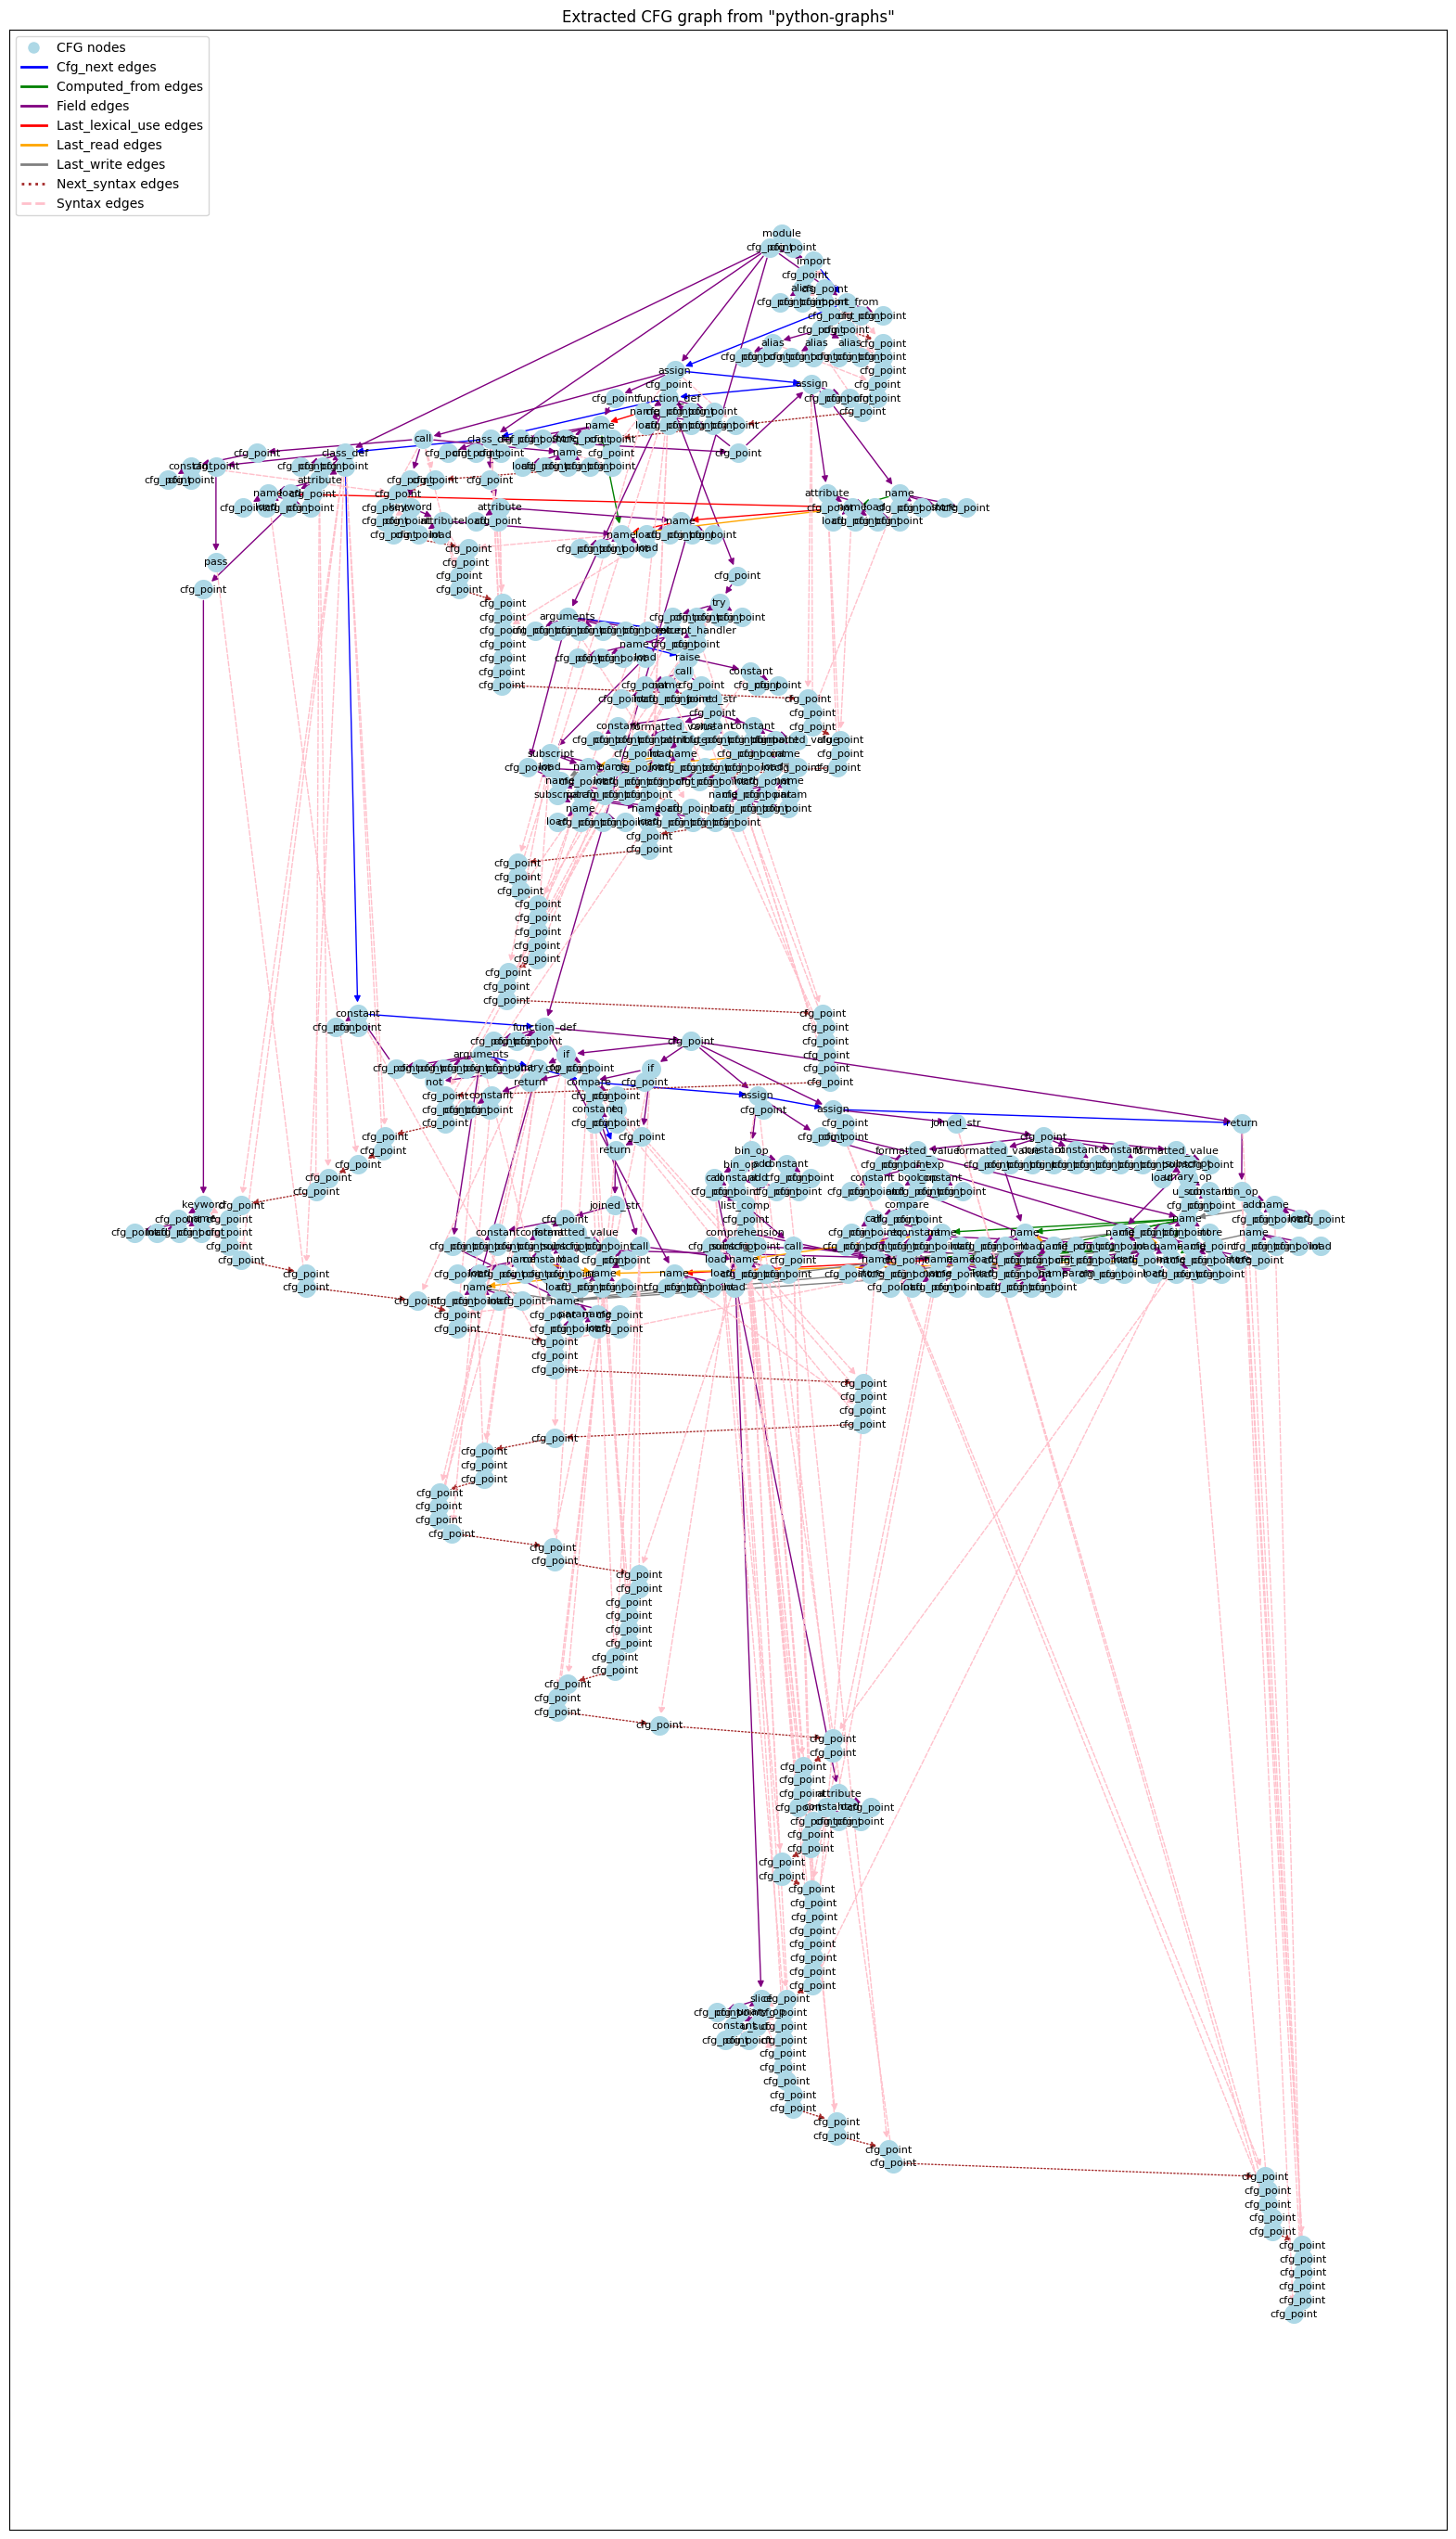

In [22]:
def visualize_graph(graph):
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog="dot")

    cfg_node = [n for n, d in graph.nodes(data=True) if 'cfg' == d['node_type']]
    # cfg_statement = [n for n, d in graph.nodes(data=True) if 'cfg_statement' == d['node_type']]
    # cfg_f_block = [n for n, d in graph.nodes(data=True) if 'cfg_f_block' == d['node_type']]
    # cfg_exitcase = [n for n, d in graph.nodes(data=True) if 'cfg_exitcase' == d['node_type']]

    
    # ast_nodes = [n for n, d in graph.nodes(data=True) if 'ast' in d['node_type']]
    # symbol_nodes = [n for n, d in graph.nodes(data=True) if 'ch22' in d['node_type']]
    # dg_nodes = [n for n, d in graph.nodes(data=True) if 'dg' in d['node_type']]

    plt.figure(figsize=(20, 35))

    # Draw nodes with different colors
    nx.draw_networkx_nodes(graph, pos, nodelist=cfg_node, node_color='lightblue', node_size=200, label='CFG node')
    # nx.draw_networkx_nodes(graph, pos, nodelist=cfg_statement, node_color='lightgreen', node_size=200, label='Statement nodes')
    # nx.draw_networkx_nodes(graph, pos, nodelist=cfg_f_block, node_color='yellow', node_size=200, label='Function blocks')
    # nx.draw_networkx_nodes(graph, pos, nodelist=cfg_exitcase, node_color='lightcoral', node_size=200, label='Exit-case nodes')

    # Explicitly define edge styles
    edge_styles = {
        'cfg_next': ('blue', 'solid'),
        'computed_from': ('green', 'solid'),
        'field': ('purple', 'solid'),
        'last_lexical_use': ('red', 'solid'),
        'last_read': ('orange', 'solid'),
        'last_write': ('gray', 'solid'),
        'next_syntax': ('brown', 'dotted'),
        'syntax': ('pink', 'dashed'),
    }

    # Draw edges with different styles
    for edge_type, (color, style) in edge_styles.items():
        edges = [(u, v) for u, v, d in graph.edges(data=True) if d['type'] == edge_type]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=color, style=style, label=f'{edge_type} edges')

    # Draw labels
    labels = {n: d['type'] for n, d in graph.nodes(data=True)}
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)

    # Custom legend for nodes
    node_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='CFG nodes'),
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Statement nodes'),
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Function blocks'),
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, label='Exit-case nodes'),
    ]

    # Custom legend for edges
    edge_legend = [
        Line2D([0], [0], color=color, lw=2, linestyle=style, label=f'{edge_type.capitalize()} edges')
        for edge_type, (color, style) in edge_styles.items()
    ]

    # Combine legends
    plt.legend(handles=node_legend + edge_legend, loc='upper left')
    plt.title('Extracted CFG graph from "python-graphs"')
    plt.show()

visualize_graph(cfg_graph)

In [13]:
from python_graphs import program_graph_graphviz

graph = program_graph.get_program_graph(code.decode())
program_graph_graphviz.render(graph, "pg_viz.png")

In [311]:
# Function to find the closest AST node
def find_closest_ast_node(cfg_node: nx.DiGraph, ast_graph: nx.DiGraph) -> str | None:
    cfg_start_line = cfg_node["start_line"]
    cfg_end_line = cfg_node["end_line"]
    cfg_start_col = cfg_node["start_col"]
    cfg_end_col = cfg_node["end_col"]
    if (
        cfg_start_line == -1
        or cfg_start_col == -1
        or cfg_end_col == -1
        or cfg_end_line == -1
    ):
        return None

    # Exact match
    for ast_node_id, ast_node_data in ast_graph.nodes(data=True):
        if (
            ast_node_data.get("node_type") == "ast"
            and cfg_start_line == ast_node_data.get("start_line")
            and cfg_end_line == ast_node_data.get("end_line")
            and cfg_start_col == ast_node_data.get("start_col")
            and cfg_end_col == ast_node_data.get("end_col")
        ):
            return ast_node_id

    # Hierarchical match
    for ast_node_id, ast_node_data in ast_graph.nodes(data=True):
        if (
            ast_node_data.get("node_type") == "ast"
            and cfg_start_line >= ast_node_data.get("start_line")
            and cfg_end_line <= ast_node_data.get("end_line")
            and cfg_start_col >= ast_node_data.get("start_col")
            and cfg_end_col <= ast_node_data.get("end_col")
        ):
            return ast_node_id

    # Proximity match
    closest_node = None
    closest_distance = float("inf")
    for ast_node_id, ast_node_data in ast_graph.nodes(data=True):
        if ast_node_data.get("node_type") == "ast":
            distance = (
                abs(cfg_start_line - ast_node_data.get("start_line"))
                + abs(cfg_end_line - ast_node_data.get("end_line"))
                + abs(cfg_start_col - ast_node_data.get("start_col"))
                + abs(cfg_end_col - ast_node_data.get("end_col"))
            )
            if distance < closest_distance:
                closest_distance = distance
                closest_node = ast_node_id

    return closest_node

In [317]:
combined_graph = combine_cfg_ast(cfg_graph, ast_graph)

In [318]:
set(nx.get_edge_attributes(combined_graph, 'type').values())

{'cfg_next',
 'child',
 'field',
 'import',
 'last_read',
 'last_write',
 'matches',
 'may_next_use',
 'next_syntax',
 'occurrence_of',
 'syntax'}

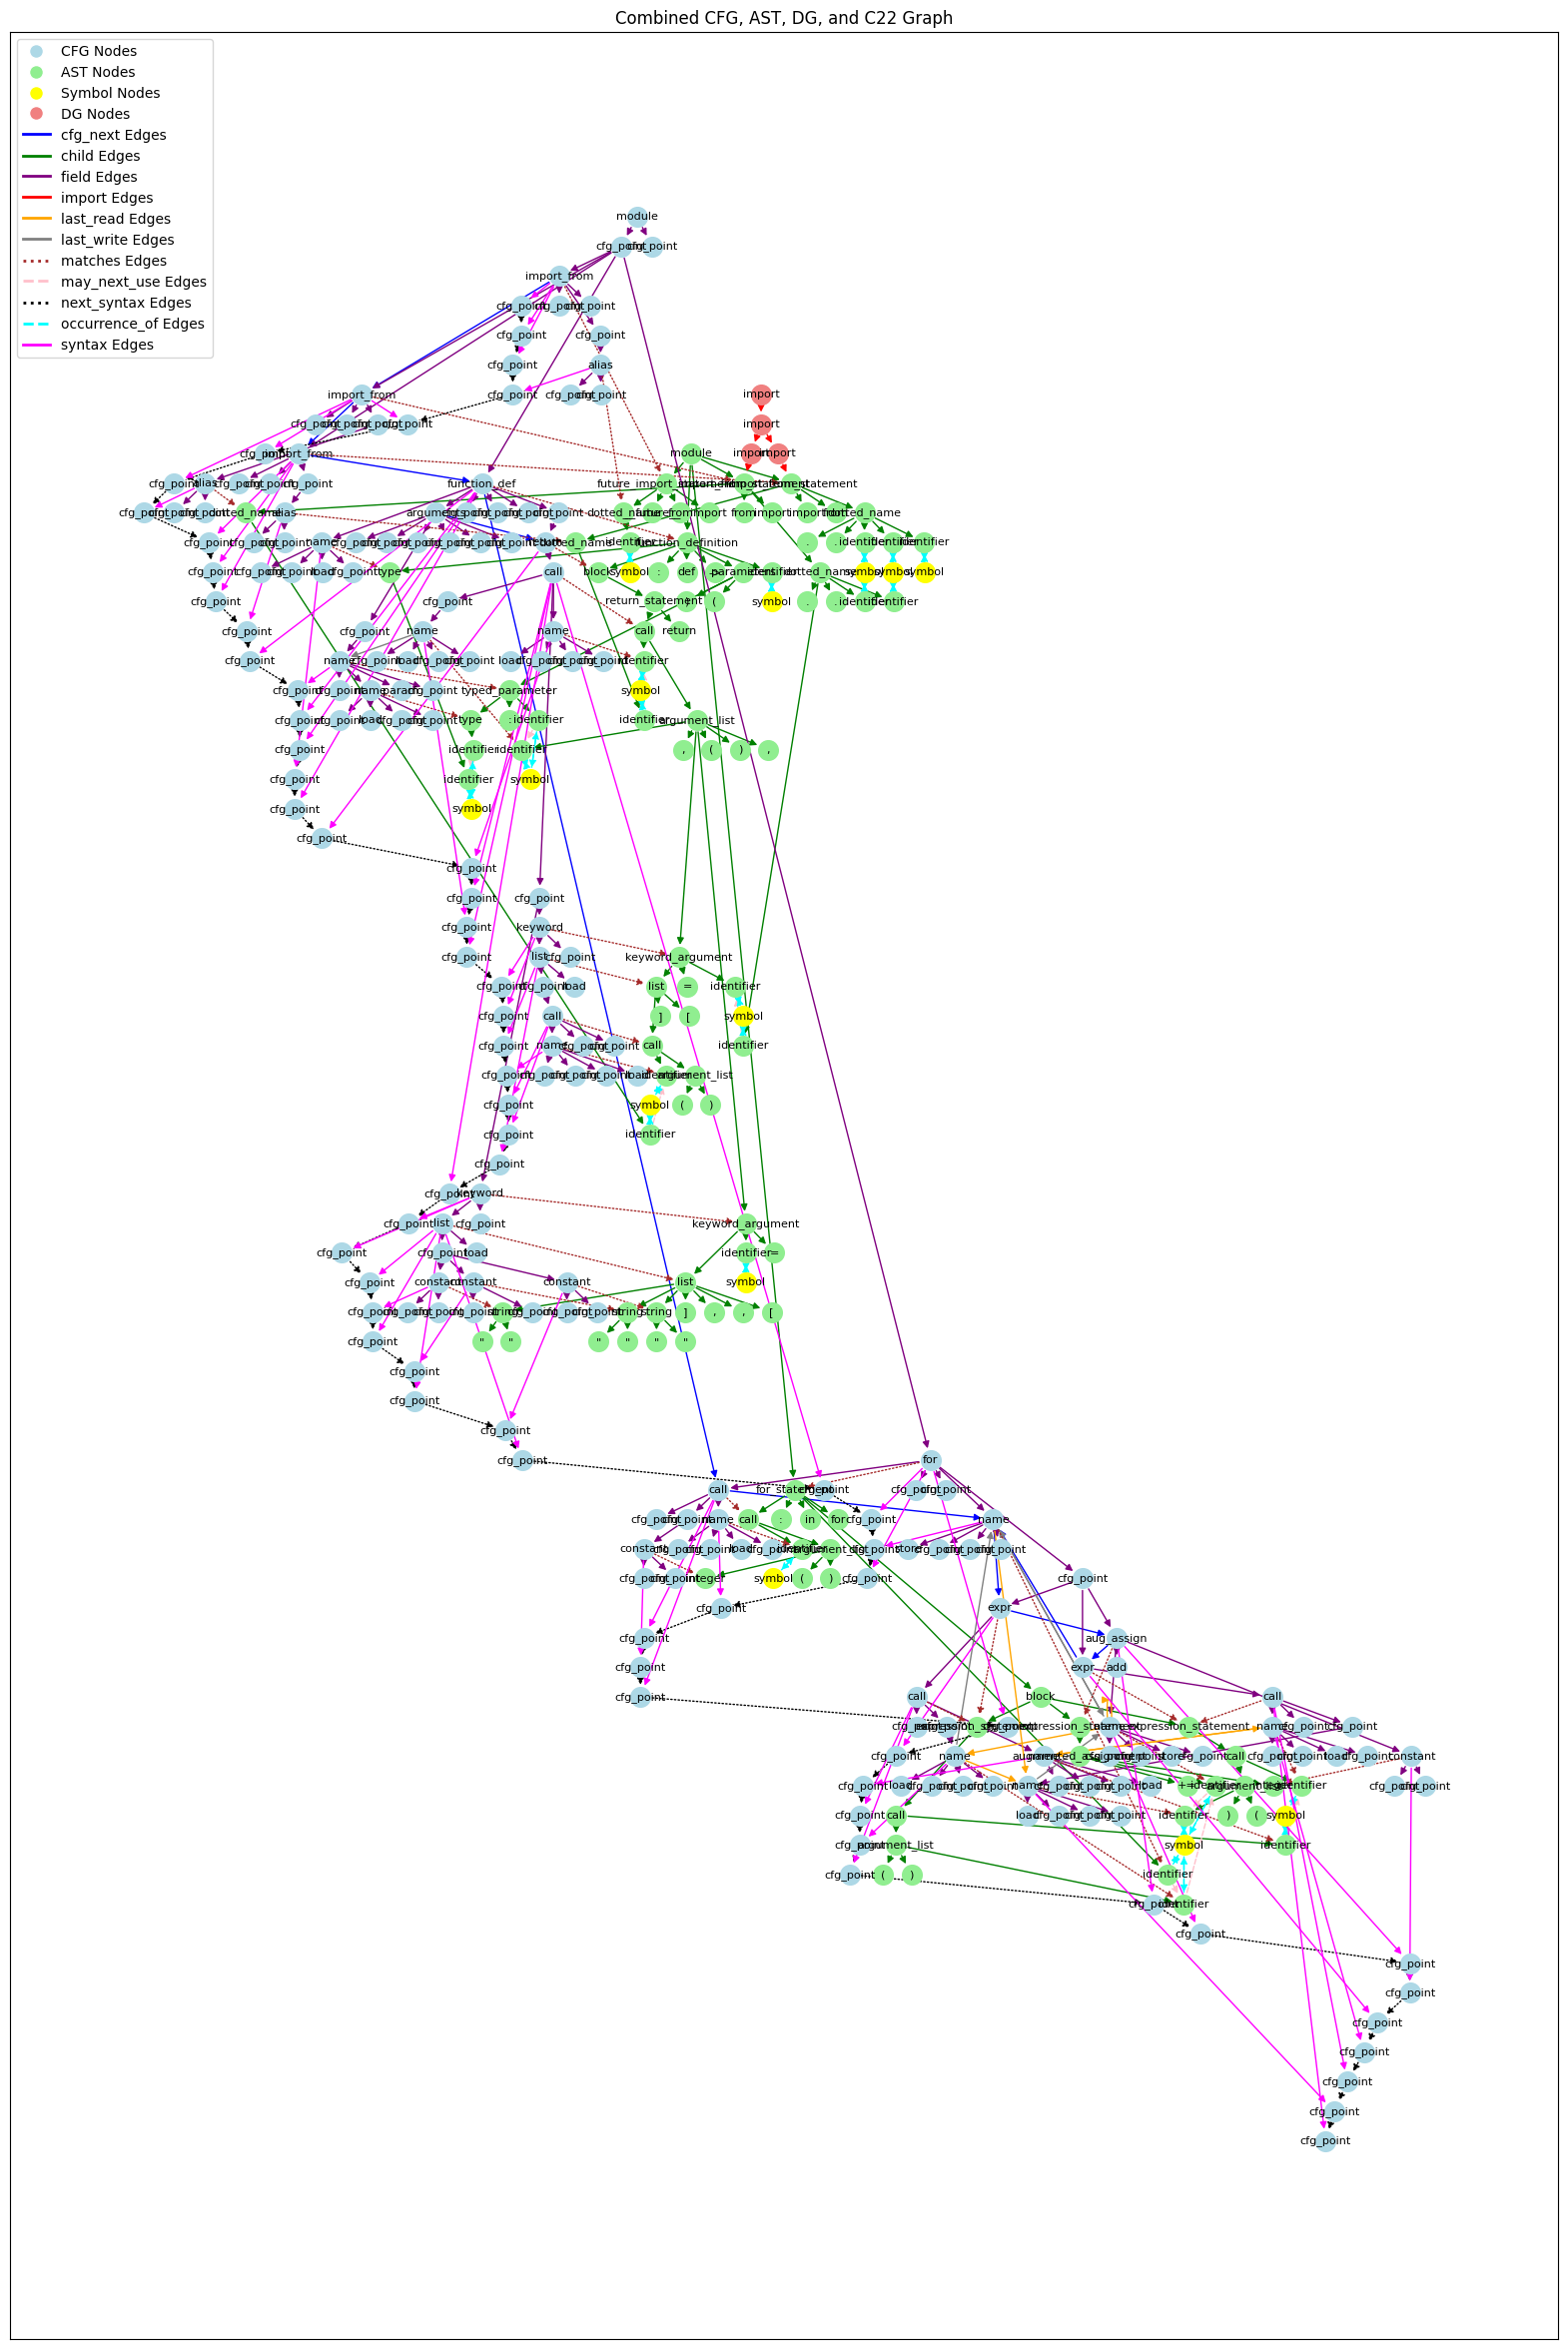

In [319]:
def random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])

def visualize_graph(graph):
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog="dot")

    cfg_nodes = [n for n, d in graph.nodes(data=True) if 'cfg' in d['node_type']]
    ast_nodes = [n for n, d in graph.nodes(data=True) if 'ast' in d['node_type']]
    symbol_nodes = [n for n, d in graph.nodes(data=True) if 'ch22' in d['node_type']]
    dg_nodes = [n for n, d in graph.nodes(data=True) if 'dg' in d['node_type']]

    plt.figure(figsize=(20, 30))

    # Draw nodes with different colors
    nx.draw_networkx_nodes(graph, pos, nodelist=cfg_nodes, node_color='lightblue', node_size=200, label='CFG Nodes')
    nx.draw_networkx_nodes(graph, pos, nodelist=ast_nodes, node_color='lightgreen', node_size=200, label='AST Nodes')
    nx.draw_networkx_nodes(graph, pos, nodelist=symbol_nodes, node_color='yellow', node_size=200, label='Symbol Nodes')
    nx.draw_networkx_nodes(graph, pos, nodelist=dg_nodes, node_color='lightcoral', node_size=200, label='DG Nodes')

    # Explicitly define edge styles
    edge_styles = {
        'cfg_next': ('blue', 'solid'),
        'child': ('green', 'solid'),
        'field': ('purple', 'solid'),
        'import': ('red', 'solid'),
        'last_read': ('orange', 'solid'),
        'last_write': ('gray', 'solid'),
        'matches': ('brown', 'dotted'),
        'may_next_use': ('pink', 'dashed'),
        'next_syntax': ('black', 'dotted'),
        'occurrence_of': ('cyan', 'dashed'),
        'syntax': ('magenta', 'solid')
    }

    # Draw edges with different styles
    for edge_type, (color, style) in edge_styles.items():
        edges = [(u, v) for u, v, d in graph.edges(data=True) if d['type'] == edge_type]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=color, style=style, label=f'{edge_type} edges')

    # Draw labels
    labels = {n: d['type'] for n, d in graph.nodes(data=True)}
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)

    # Custom legend for nodes
    node_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='CFG Nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='AST Nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Symbol Nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, label='DG Nodes'),
    ]

    # Custom legend for edges
    edge_legend = [
        Line2D([0], [0], color=color, lw=2, linestyle=style, label=f'{edge_type} Edges')
        for edge_type, (color, style) in edge_styles.items()
    ]

    # Combine legends
    plt.legend(handles=node_legend + edge_legend, loc='upper left')
    plt.title("Combined CFG, AST, DG, and C22 Graph")
    plt.show()

visualize_graph(combined_graph)

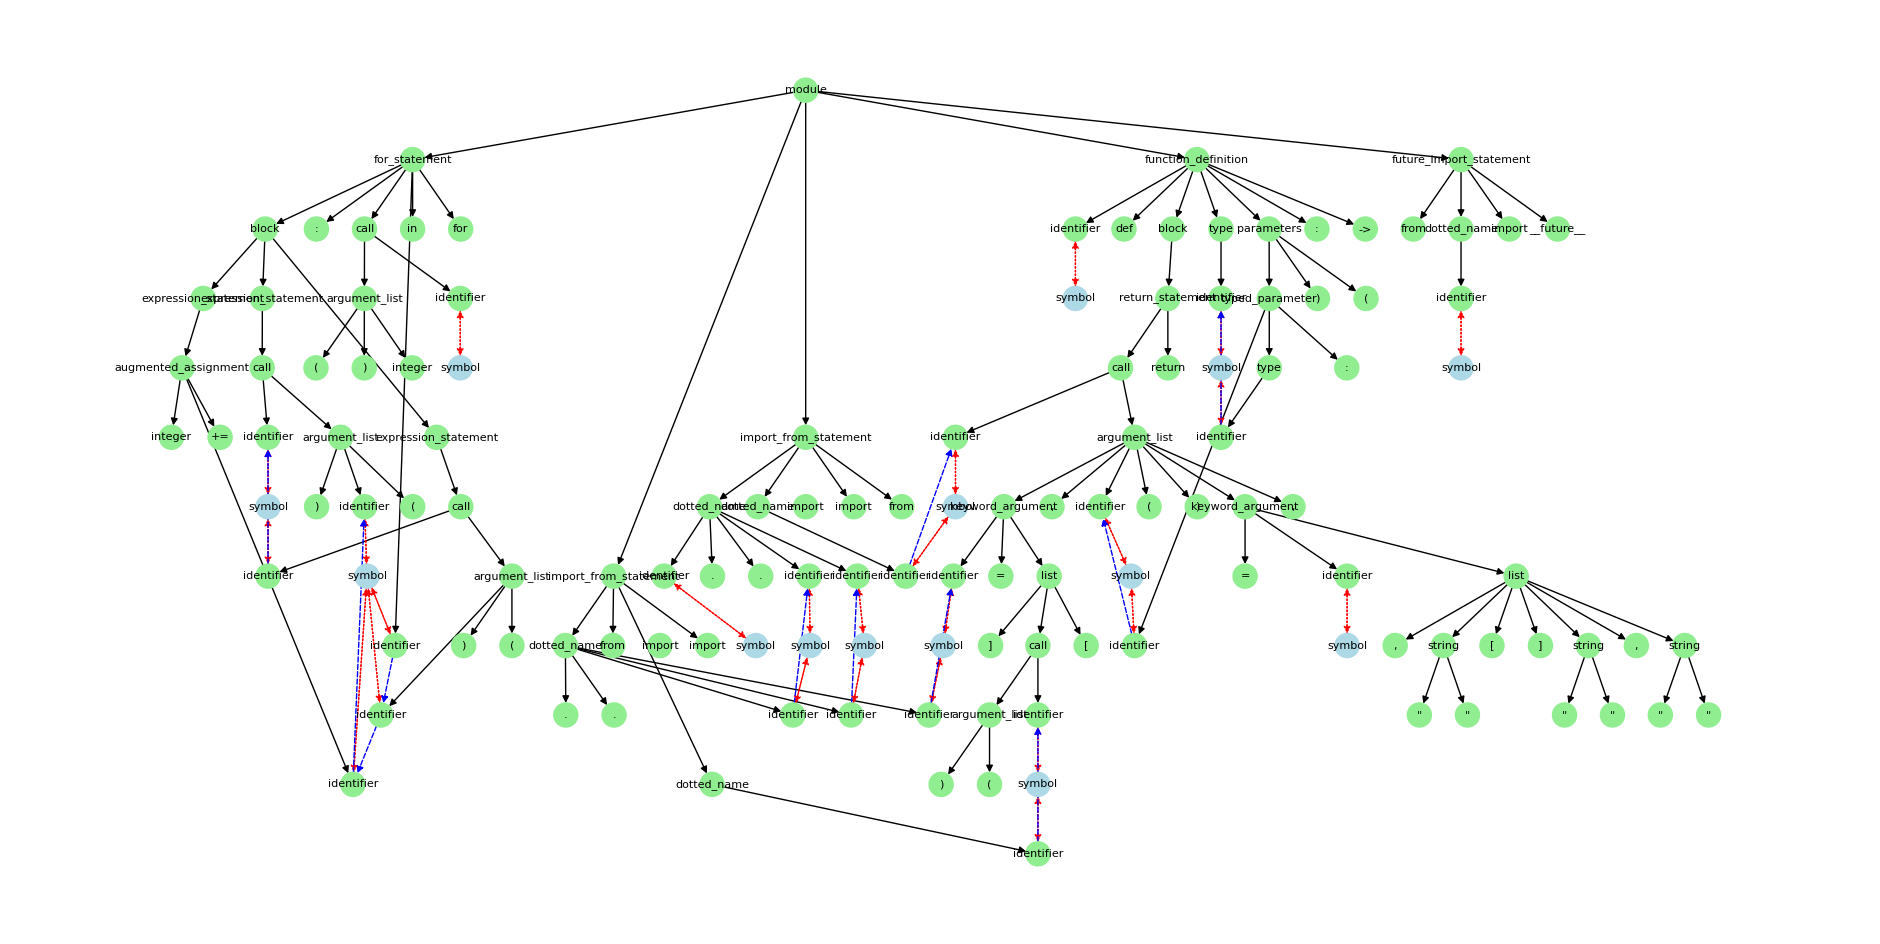

In [32]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(G):
    # Define colors and styles for different types of nodes and edges
    edge_colors = {"child": "black", "occurance_of": "red", "may_next_use": "blue"}
    node_colors = {node: "lightblue" if data['type'] == 'symbol' else "lightgreen" for node, data in G.nodes(data=True)}
    
    # Different styles for different types of edges
    edge_styles = {"child": "solid", "occurance_of": "dotted", "may_next_use": "dashed"}
    
    # Using a larger figure size to better spread nodes
    plt.figure(figsize=(24, 12))  # Wider figure to spread out the nodes

    # Adjusting layout settings to spread nodes further apart
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # Use 'dot' or try 'neato' if available

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()], node_size=300)

    # Draw edges by type for different styling
    for edge_type in edge_colors:
        edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == edge_type]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors[edge_type], style=edge_styles[edge_type])

    # Labels
    labels = {node: f"{data['type']}" for node, data in G.nodes(data=True)}  # Include content in labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    # plt.title("AST with Semantic Edges")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Visualize the graph
visualize_graph(tree)

In [13]:
types

{'"',
 '(',
 ')',
 '+',
 ',',
 ':',
 '=',
 '==',
 'argument_list',
 'assignment',
 'binary_operator',
 'block',
 'call',
 'comparison_operator',
 'def',
 'expression_statement',
 'function_definition',
 'identifier',
 'if',
 'if_statement',
 'integer',
 'interpolation',
 'module',
 'parameters',
 'return',
 'return_statement',
 'string',
 '{',
 '}'}